In [5]:
!pip install datasets
!pip install hdbscan
!pip install datamapplot
!pip install umap-learn
!pip install bertopic
!pip install wordcloud

### AsXiV Articles: Computation and language


In [6]:
from datasets import load_dataset

dataset = load_dataset('maartengr/arxiv_nlp')['train']

abstracts = list(dataset['Abstracts'])
titles = list(dataset['Titles'])

## A comppn pipeline for text clustering


### 1. Embedding documents


In [7]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [8]:
embeddings.shape

(44949, 384)

### 2. Reducing the dimensionaility of embeddings


In [9]:
from umap import UMAP

umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 3. Cluster the reduced embeddings


In [10]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', cluster_selection_method='eom').fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# How many clusters did we generate
len(set(clusters))

155

### Inspecting the clusters


In [11]:
import numpy as np

cluster = 0

for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:200] + '... \n')

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesiz... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focu... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation syste... 



In [12]:
import pandas as pd

reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
df['title'] = titles
df['cluster'] = [str(c) for c in clusters]

clusters_df = df.loc[df.cluster != '-1', :]
outliers_df = df.loc[df.cluster == '-1', :]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Static plot


(np.float64(-7.282655382156372),
 np.float64(11.277046823501587),
 np.float64(-6.28760678768158),
 np.float64(10.93724067211151))

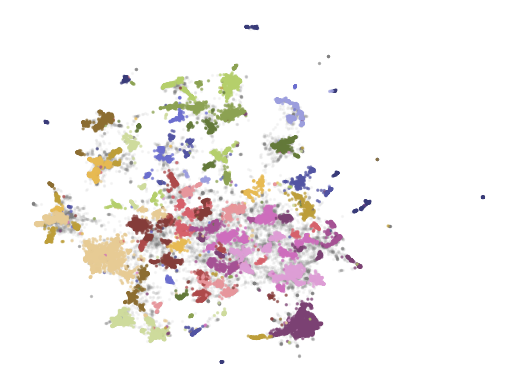

In [13]:
import matplotlib.pyplot as plt

plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c='grey')
plt.scatter(clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int), alpha=0.6, s=2, cmap='tab20b')
plt.axis('off')

## From text clustering to topic modeling


### BERTopic: A modular topic modeling framework


In [14]:
from bertopic import BERTopic

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-12-24 15:56:33,613 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-24 15:57:24,475 - BERTopic - Dimensionality - Completed ✓
2025-12-24 15:57:24,477 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-24 15:57:26,574 - BERTopic - Cluster - Completed ✓
2025-12-24 15:57:26,586 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-24 15:57:30,353 - BERTopic - Representation - Completed ✓


In [15]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14830                               -1_the_of_and_to   
1        0   2203                 0_question_qa_answer_questions   
2        1   1972                   1_speech_asr_recognition_end   
3        2    859              2_hate_offensive_speech_detection   
4        3    848  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
150    149     53           149_counseling_mental_therapy_health   
151    150     53                150_mixed_code_sentiment_mixing   
152    151     53      151_prompt_prompts_optimization_prompting   
153    152     50                 152_long_context_window_length   
154    153     50                     153_chatgpt_its_openai_has   

                                        Representation  \
0    [the, of, and, to, in, we, for, language, that...   
1    [question, qa, answer, questions, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [hate, offensive, speech, detection, toxic, so...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
150  [counseling, mental, therapy, health, psychoth...   
151  [mixed, code, sentiment, mixing, english, anal...   
152  [prompt, prompts, optimization, prompting, llm...   
153  [long, context, window, length, llms, contexts...   
154  [chatgpt, its, openai, has, ai, tasks, respons...   

                                   Representative_Docs  
0    [  Word Representations form the core componen...  
1    [  With the development of deep learning techn...  
2    [  End-to-end Speech Translation (ST) models h...  
3    [  With growing role of social media in shapin...  
4    [  Pre-trained neural abstractive summarizatio...  
..                                                 ...  
150  [  Mental health care poses an increasingly se...  
151  [  The usage of more than one language in the ...  
152  [  Prompt optimization aims to find the best p...  
153  [  Extending the context window of large langu...  
154  [  Recently, ChatGPT has attracted great atten...  

[155 rows x 5 columns]

In [16]:
topic_model.get_topic(0)

[('question', np.float64(0.021513659402328498)),
 ('qa', np.float64(0.01599542005307066)),
 ('answer', np.float64(0.01598355249769436)),
 ('questions', np.float64(0.015939920753689895)),
 ('answering', np.float64(0.015001840362609379)),
 ('answers', np.float64(0.009914565594237793)),
 ('retrieval', np.float64(0.009494874277091257)),
 ('comprehension', np.float64(0.007755949913161138)),
 ('reading', np.float64(0.0072157025360459525)),
 ('knowledge', np.float64(0.006384494984848137))]

In [17]:
topic_model.find_topics('topic modelling')

([26, -1, 47, 34, 112],
 [np.float32(0.94734955),
  np.float32(0.9067154),
  np.float32(0.9058295),
  np.float32(0.899698),
  np.float32(0.89838487)])

In [18]:
topic_model.get_topic(22)

[('classification', np.float64(0.027700659966214014)),
 ('label', np.float64(0.027298282460681503)),
 ('labels', np.float64(0.017843140375134993)),
 ('text', np.float64(0.01573274215114283)),
 ('hierarchical', np.float64(0.009962405511364982)),
 ('document', np.float64(0.008967767600591724)),
 ('class', np.float64(0.008105128616428021)),
 ('documents', np.float64(0.0077769277051026025)),
 ('hierarchy', np.float64(0.007529893215227781)),
 ('multi', np.float64(0.006948802731317293))]

In [19]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

26

### Visualizations


#### Visualize documents


In [20]:
fig = topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, width=1200, hide_annotations=True)

fig.update_layout(font=dict(size=16))

In [21]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

# Visualize the potential hierarchial structure of topics
topic_model.visualize_hierarchy()

### Representation models


In [22]:
from copy import deepcopy

original_topics = deepcopy(topic_model.topic_representations_)

In [23]:
def topic_differences(model, original_topics, nr_topics=5):
    df = pd.DataFrame(columns=['Topics', 'Original', 'Updated'])
    
    for topic in range(nr_topics):
        og_words = ' | '.join(list(zip(*original_topics[topic]))[0][:5])
        new_words = ' | '.join(list(zip(*model.get_topic(topic)))[0][:5])
        
        df.loc[len(df)] = [topic, og_words, new_words]
        
    return df

### KeyBERTInspired


In [24]:
from bertopic.representation import KeyBERTInspired

representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

Topics                                           Original  \
0       0     question | qa | answer | questions | answering   
1       1        speech | asr | recognition | end | acoustic   
2       2      hate | offensive | speech | detection | toxic   
3       3  summarization | summaries | summary | abstract...   
4       4      gender | bias | biases | debiasing | fairness   

                                             Updated  
0  questions | answering | comprehension | questi...  
1  translation | speech | transcription | phoneti...  
2  hate | hateful | language | classifiers | twitter  
3  summarization | summarizers | summaries | summ...  
4         gender | gendered | bias | biases | biased

### Maximal marginal relevance


In [25]:
from bertopic.representation import MaximalMarginalRelevance

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

Topics                                           Original  \
0       0     question | qa | answer | questions | answering   
1       1        speech | asr | recognition | end | acoustic   
2       2      hate | offensive | speech | detection | toxic   
3       3  summarization | summaries | summary | abstract...   
4       4      gender | bias | biases | debiasing | fairness   

                                             Updated  
0  questions | retrieval | comprehension | knowle...  
1        speech | asr | model | automatic | training  
2       hate | toxic | social | comments | platforms  
3  summarization | extractive | factual | sentenc...  
4  gender | bias | fairness | stereotypes | embed...

## Text Generation


### Flan T5


In [26]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(generator, prompt=prompt, doc_length=50, tokenizer='whitespace')
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

Device set to use cuda:0
100%|██████████| 155/155 [00:51<00:00,  3.04it/s]


Topics                                           Original  \
0       0     question | qa | answer | questions | answering   
1       1        speech | asr | recognition | end | acoustic   
2       2      hate | offensive | speech | detection | toxic   
3       3  summarization | summaries | summary | abstract...   
4       4      gender | bias | biases | debiasing | fairness   

                                             Updated  
0  Question answering is one of the most importan...  
1     Speech-to-speech comparison metric |  |  |  |   
2                           Science/Tech |  |  |  |   
3                 Document summarization |  |  |  |   
4  Gender bias in artificial intelligence and nat...

### Documents and topics


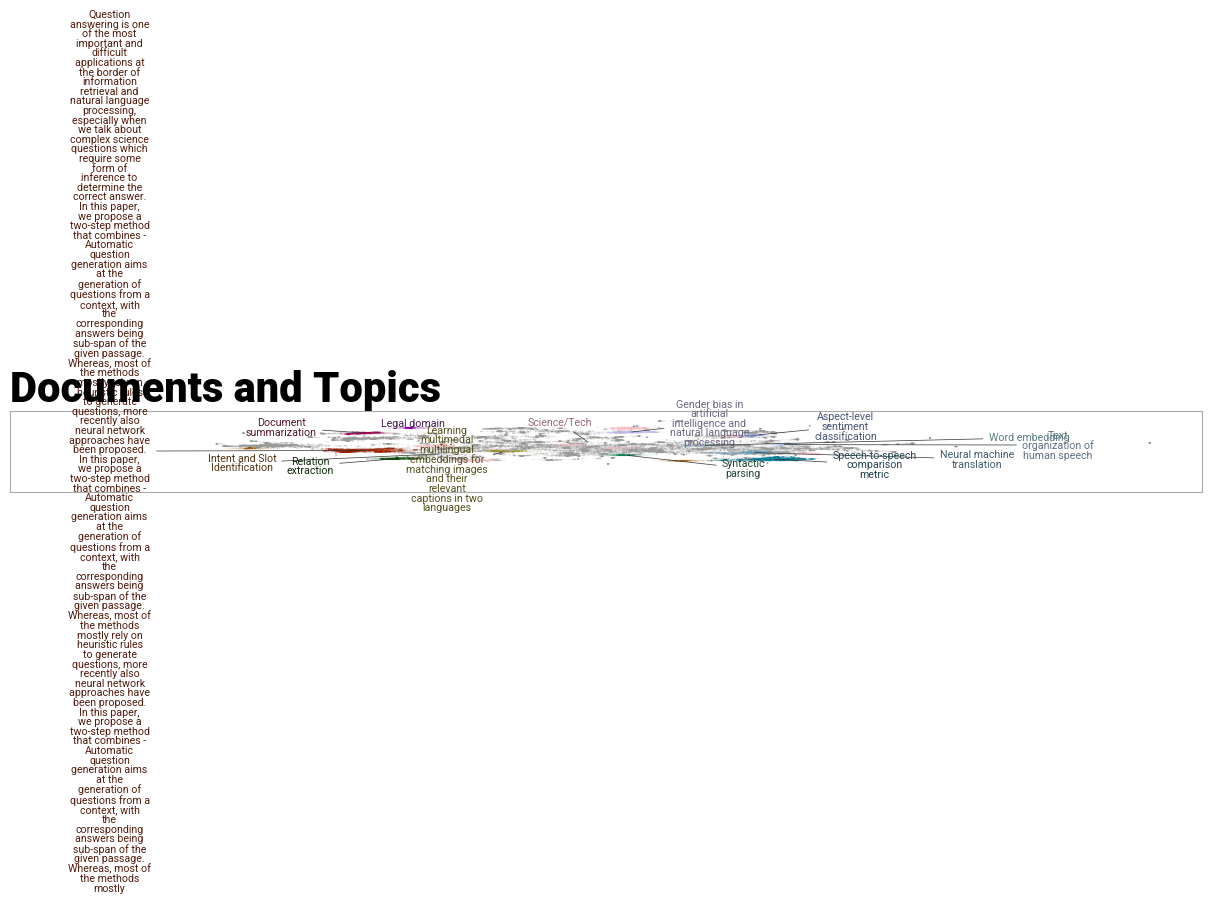

In [27]:
import datamapplot

fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    # label_font_size=11,
    # label_wrap_width=20,
    # use_medoids=True
)

plt.savefig('datamapplot.png', dpi=300)

## Bonus: Word cloud


2025-12-24 16:00:50,415 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


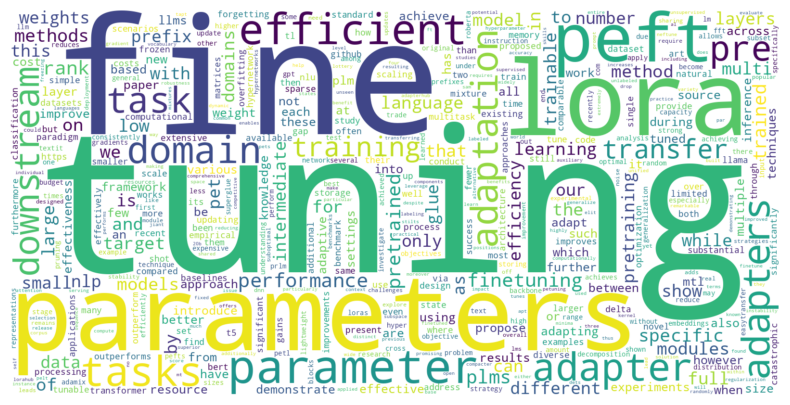

In [30]:
topic_model.update_topics(abstracts, top_n_words=500)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10, 5))
    text={word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color='white', max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
create_wordcloud(topic_model, topic=17)